# Chest X‑Ray Pneumonia Detection — Deep Learning Case Study 

This notebook consolidates prior variations (training vs. pretrained, with/without callbacks, multiple backbones) into one **case study**.  
It demonstrates **transfer learning** for classifying **Pneumonia vs Normal** chest X‑rays, with:
- Multiple **backbone options** (MobileNetV2, EfficientNetB0, DenseNet121, ResNet50, EfficientNetB3)
- Two **usage modes**: Load a **pretrained** model or **Train** (frozen base ➜ fine‑tune)
- **Callbacks** (EarlyStopping + ModelCheckpoint) to save the best model before overfitting
- **Evaluation**: Confusion matrix, classification report, ROC‑AUC, and **learning curves** with fine‑tuning marker


the pretrained model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

we test two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. we add a new classifier, which will be trained from scratch, on top of the pretrained model so that it can repurpose the feature maps learned previously for the dataset.

 we do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

at the end we evaluate each result and compare the methods 

## 1. Data preprocessing and Configuration

will use a dataset containing several thousand images of Pneumonia vs Normal chest X-rays. Downloaded from https://universe.roboflow.com/mohamed-traore-2ekkp/chest-x-rays-qjmia/dataset/4 

- `DATASET_ROOT` must contain `train/`, `valid/`, and `test/` subfolders.
- Select `BACKBONE` and `MODE`:
- `USE_CLASS_WEIGHTS` handles class imbalance.

In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

#from google.colab import drive
#drive.mount('/content/drive')
#BASE_DIR = "/content/drive/MyDrive/chest_xrays_v4"

BASE_DIR = r"C:\\CAS AML\\project M1 and M2\\Chest X Rays v4"  # change if needed
MODEL_PATH = os.path.join(BASE_DIR, f"pneumonia_xray_mobilenet.keras")


train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'valid')
test_dir = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (416, 416)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            labels='inferred',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 labels='inferred',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Show the first nine images and labels from the training set:

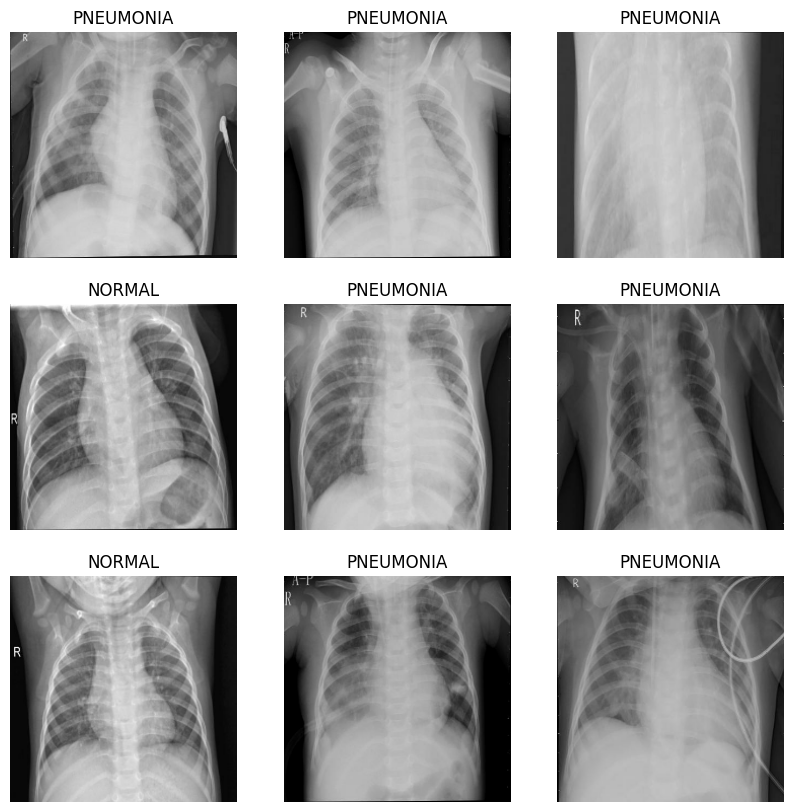

In [54]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 1.1 Use data augmentation

Pre-loaded Augmentations

Outputs per training example: 3

Shear: ±3° Horizontal, ±2° Vertical

Saturation: Between -5% and +5%

Brightness: Between -5% and +5%

Exposure: Between -5% and +5%

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [58]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

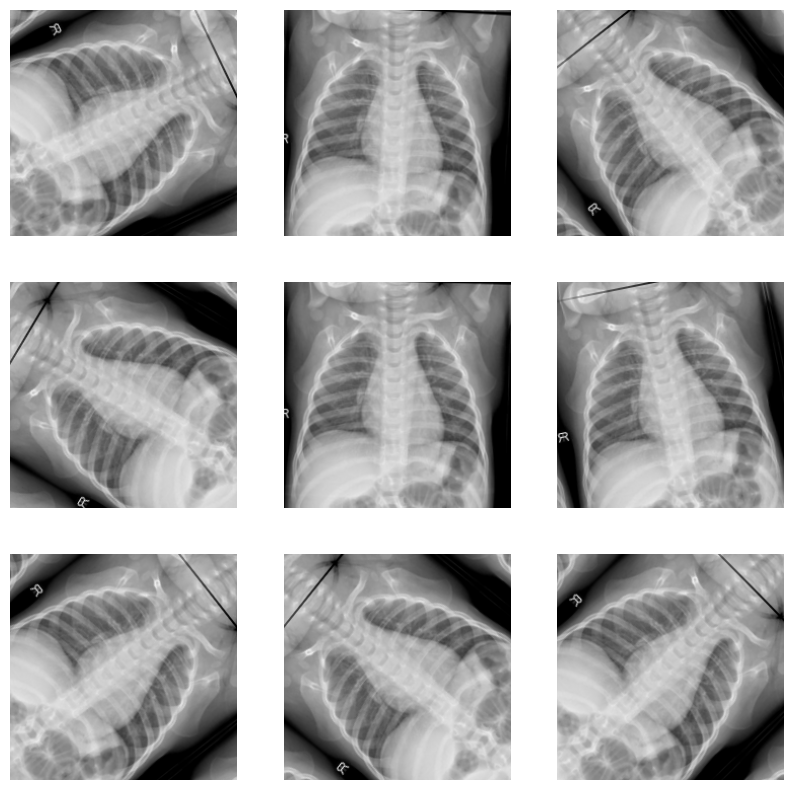

In [59]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 1.2 Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [60]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify Pneumonia vs Normal chest X-rays from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [61]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [62]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## 2.1 Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [63]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [64]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## 2.2 Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [65]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [66]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [67]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [68]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

## 2.3 Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [70]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# 3. Train the model

Before training check accuracy on the validation set.


In [71]:
loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step - accuracy: 0.4902 - loss: 0.7182


In [72]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.49


After training for 10 epochs, you should see ~96% accuracy on the validation set.

## Training with Callbacks (EarlyStopping + ModelCheckpoint)

In [74]:
# Define callbacks to prevent overfitting and save best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)

# Train with callbacks
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# At the end, model already has the best weights restored
print("Best model saved at:", MODEL_PATH)


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7400 - loss: 0.5140
Epoch 1: val_accuracy improved from -inf to 0.91073, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_mobilenet.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 203s 522ms/step - accuracy: 0.7402 - loss: 0.5138 - val_accuracy: 0.9107 - val_loss: 0.2947
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8896 - loss: 0.2945
Epoch 2: val_accuracy improved from 0.91073 to 0.93199, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_mobilenet.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 186s 484ms/step - accuracy: 0.8897 - loss: 0.2945 - val_accuracy: 0.9320 - val_loss: 0.2250
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9189 - loss: 0.2293
Epoch 3: val_accuracy improved from 0.93199 to 0.93624, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_mobilenet.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 182s 474ms/step

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

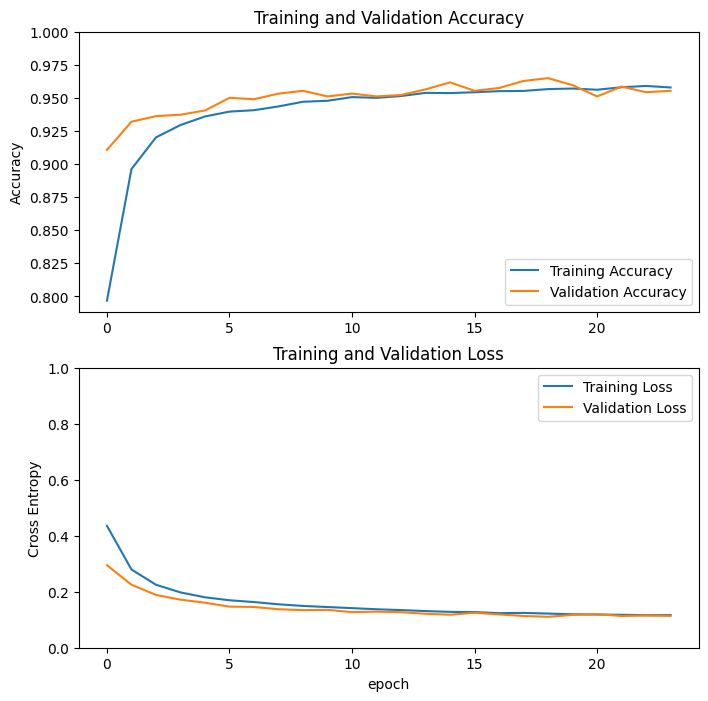

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

# 4. Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

## 4.1 Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [76]:
base_model.trainable = True

In [77]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [78]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [79]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [80]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

## Training with Callbacks (EarlyStopping + ModelCheckpoint)

In [81]:
# Define callbacks to prevent overfitting and save best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)

# Train with callbacks
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# At the end, model already has the best weights restored
print("Best model saved at:", MODEL_PATH)


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9011 - loss: 0.2480
Epoch 1: val_accuracy improved from -inf to 0.94474, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_mobilenet.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 291s 731ms/step - accuracy: 0.9012 - loss: 0.2478 - val_accuracy: 0.9447 - val_loss: 0.1457
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9636 - loss: 0.0948
Epoch 2: val_accuracy improved from 0.94474 to 0.96812, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_mobilenet.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 277s 724ms/step - accuracy: 0.9637 - loss: 0.0947 - val_accuracy: 0.9681 - val_loss: 0.1026
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9767 - loss: 0.0611
Epoch 3: val_accuracy improved from 0.96812 to 0.97343, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_mobilenet.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 277s 724ms/step

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

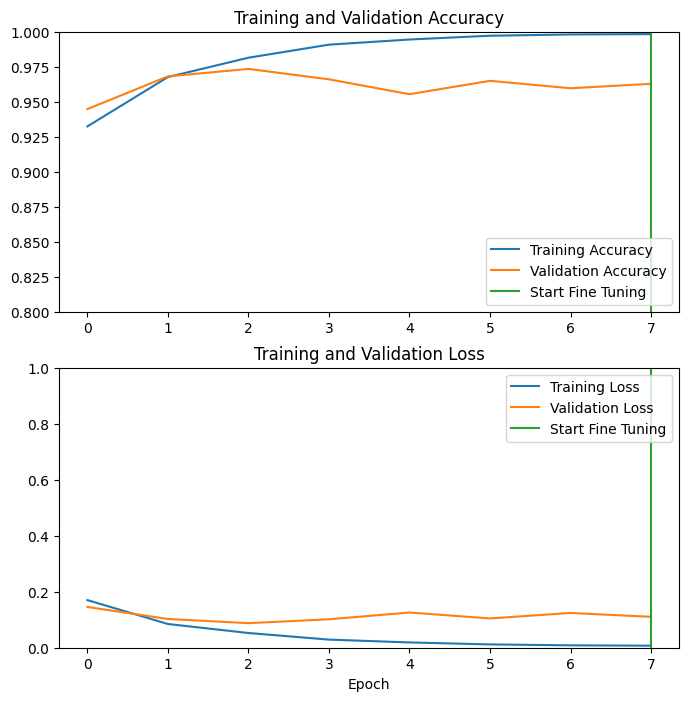

In [83]:
# Set this to the number of epochs from the initial training
initial_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


# 5. Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [84]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9668 - loss: 0.0679
Test accuracy : 0.96875


And now you are all set to use this model to predict 

Predictions:
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1]
Labels:
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1]


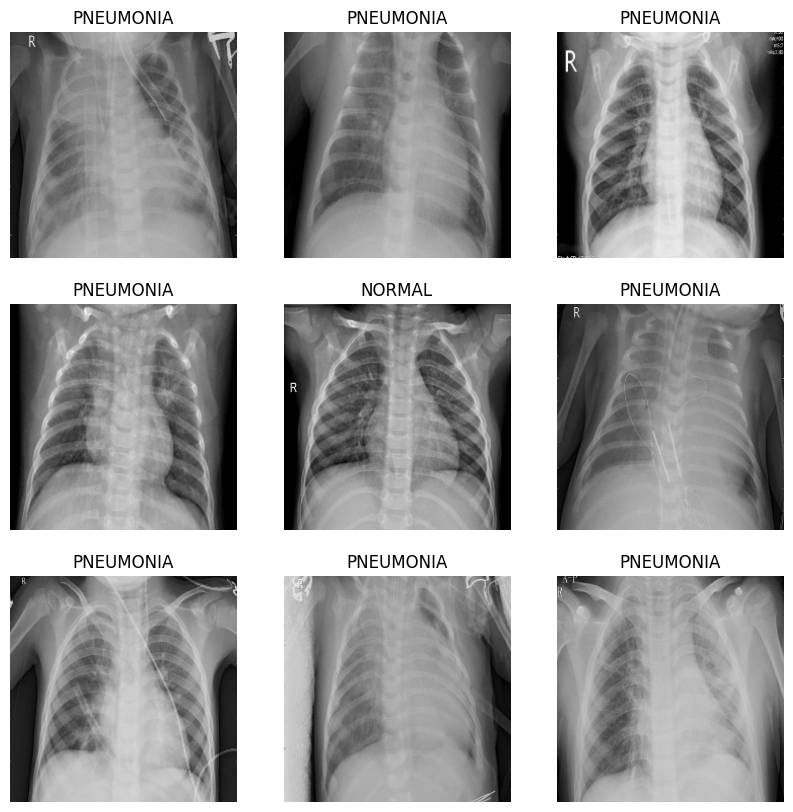

In [85]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Save the fine-tuned model

In [86]:
#model_path = '/content/gdrive/My Drive/Colab_Notebooks/my_model_CXR_cnn.keras'
MODEL_PATH = os.path.join(BASE_DIR, f"pneumonia_xray_mobilenet.keras")

tf.keras.models.save_model(filepath=MODEL_PATH, model=model)

Load the fine-tuned model and predict

Predictions:
 [1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1]
Labels:
 [1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1]


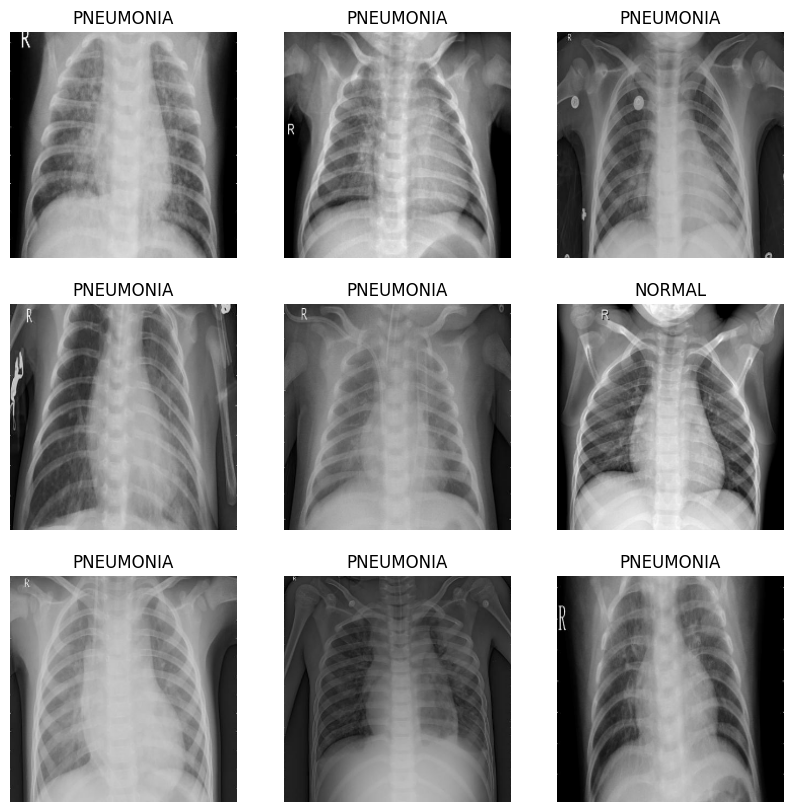

In [87]:
#model_path = '/content/gdrive/My Drive/Colab_Notebooks/my_model_CXR_cnn.keras'
modelSAVED =tf.keras.models.load_model(MODEL_PATH)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = modelSAVED.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
  
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Comparison: EfficientNetB3, EfficientNetB0, and MobileNetV2 (+ custom classifier)

🔹 EfficientNetB3

Input: (300, 300, 3)

Backbone: EfficientNetB3 (pretrained, frozen)

Parameters: ~10.8M total

Trainable (your setup): ~3,074 (top dense classifier)

Non-trainable: ~10.78M

File size: ~41 MB

Strengths: Highest accuracy potential here; modern, strong features

Weaknesses: Heavier on CPU → slower training/inference

🔹 EfficientNetB0

Input: (224, 224, 3)

Backbone: EfficientNetB0 (pretrained, frozen)

Parameters: ~5.3M total

Trainable (your setup): small top layer only (similar to B3/MobileNetV2)

Non-trainable: ~5.3M − (top layer)

File size: ~20 MB

Strengths: Excellent accuracy vs size balance; clearly stronger than MobileNetV2 while still CPU-friendly

Weaknesses: Not as strong as B3 on large/complex datasets

🔹 MobileNetV2 (your current)

Input: (224, 224, 3)

Backbone: MobileNetV2 (pretrained, frozen)

Added head: GlobalAveragePooling → Dropout → Dense(1)

Parameters: ~2.26M total

Trainable: ~1,281 (only final dense classifier)

Non-trainable: ~2.25M

File size: ~8.6 MB

Strengths: Very lightweight, fastest on CPU, smallest file

Weaknesses: Lower accuracy ceiling than EfficientNet family

Summary:

With current setup, both models are doing the same thing → only training the last classifier layer while the backbone stays frozen.

The main tradeoff is accuracy vs efficiency:

EfficientNetB3 → better accuracy but heavier.

MobileNetV2 → faster, lighter, smaller model.

EfficientNetB0 → sweet spot: noticeably better than MobileNetV2 while still compact and CPU-friendly.